In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Import Captum for interpretability
from captum.attr import IntegratedGradients

import warnings
warnings.filterwarnings('ignore')

In [13]:
# Load the dataset
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83']
data.drop(columns=cols_to_drop, inplace=True)

# Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop these columns from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# Display confirmation of saved and deleted columns
print("Saved apache columns in a separate DataFrame and removed them from the main dataset.")
print("Apache Probabilities DataFrame:")
print(apache_probs.head())


# Replace the lowercase value with the uppercase value to combine these categories
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Verify that the categories have been combined
print("Value Counts for 'apache_2_bodysystem' after combining categories:")
print(data['apache_2_bodysystem'].value_counts())
# Convert binary variables to categorical
binary_categorical_vars = [
    'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis',
    'diabetes_mellitus', 'hepatic_failure', 'immunosuppression',
    'leukemia', 'lymphoma', 'solid_tumor_with_metastasis',
    'apache_post_operative', 'arf_apache', 'gcs_unable_apache', 'elective_surgery'
]
for col in binary_categorical_vars:
    data[col] = data[col].astype('category')

# Convert target variable to integer if it's not already
data['hospital_death'] = data['hospital_death'].astype(int)

categorical_vars = ['icu_admit_source', 'ethnicity', 'gender', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_stay_type']
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

Saved apache columns in a separate DataFrame and removed them from the main dataset.
Apache Probabilities DataFrame:
   apache_4a_hospital_death_prob  apache_4a_icu_death_prob
0                           0.10                      0.05
1                           0.47                      0.29
2                           0.00                      0.00
3                           0.04                      0.03
4                            NaN                       NaN
Value Counts for 'apache_2_bodysystem' after combining categories:
apache_2_bodysystem
Cardiovascular         38816
Neurologic             11896
Respiratory            11609
Gastrointestinal        9026
Metabolic               7650
Undefined Diagnoses     4114
Trauma                  3842
Renal/Genitourinary     2460
Haematologic             638
Name: count, dtype: int64


In [14]:
# Update lists of numerical and categorical features
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

print('the list of categorical features is:', categorical_features)
print('the list of numerical features is:', numerical_features)

the list of categorical features is: ['elective_surgery', 'apache_post_operative', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
the list of numerical features is: ['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_dias

In [15]:
# check the data type of a colum in data dataframe
data['hospital_death'].dtype

dtype('int64')

In [16]:
# Handling Missing Values

# Calculate the value counts for 'hospital_death' and convert them to percentages
hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# Display the percentage distribution of hospital deaths
print("Percentage Distribution of Hospital Deaths:")
print(hospital_death_counts)

# For now, drop any rows that have missing values
data = data.dropna()

# Alternative strategies:
# - Impute numerical features using mean, median, or mode
# - Use KNN imputation or regression models to estimate missing values
# - Impute categorical features with the most frequent category or 'Unknown'
# - Use advanced imputation techniques like MICE (Multiple Imputation by Chained Equations)


# Calculate the value counts for 'hospital_death' and convert them to percentages
hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# Display the percentage distribution of hospital deaths
print("Percentage Distribution of Hospital Deaths:")
print(hospital_death_counts)

Percentage Distribution of Hospital Deaths:
hospital_death
0    91.369817
1     8.630183
Name: proportion, dtype: float64
Percentage Distribution of Hospital Deaths:
hospital_death
0    91.587413
1     8.412587
Name: proportion, dtype: float64


In [17]:
# Split the data
X = data.drop('hospital_death', axis=1)
Y = data['hospital_death']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50, stratify=Y)

In [18]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_test_scaled = scaler.transform(X_test)        # Transform test data using the same scaler

In [19]:
# Split the train dataset into train(85% of train data) and validation(15% of train data) using the train_test_split function with random_state = 50.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_scaled, Y_train, test_size=0.15, random_state=50)

In [20]:
# Apply SMOTE (if needed)
def apply_smote(X_train, Y_train):
    smote = SMOTE(random_state=50)
    X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
    return X_train_smote, Y_train_smote

# Convert Data to PyTorch Tensors
def to_tensor(X, Y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    Y_tensor = torch.tensor(Y.values.reshape(-1, 1), dtype=torch.float32)
    return X_tensor, Y_tensor

In [21]:
# Without SMOTE
X_train_tensor, Y_train_tensor = to_tensor(X_train, Y_train)
X_val_tensor, Y_val_tensor = to_tensor(X_val, Y_val)
X_test_tensor, Y_test_tensor = to_tensor(X_test_scaled, Y_test)

# With SMOTE
X_train_smote, Y_train_smote = apply_smote(X_train, Y_train)
X_train_smote_tensor, Y_train_smote_tensor = to_tensor(X_train_smote, Y_train_smote)

In [22]:
# Define the model
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
class BigModel(nn.Module):
    def __init__(self, input_size):
        super(BigModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # Adding Sigmoid for binary classification
        )

    def forward(self, x):
        return self.network(x)

In [23]:
def eval_model(model, X, Y, loss_fn, threshold=0.5):
    """
    Evaluates the model on a given dataset.
    Returns the loss and accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(X)  # Get model predictions
        loss = loss_fn(outputs, Y)  # Calculate loss
        predictions = (outputs > threshold).float()  # Convert probabilities to binary predictions
        accuracy = (predictions == Y).float().mean().item()  # Calculate accuracy
    return float(loss), accuracy, predictions

In [24]:
# Threshold search function
def find_best_threshold(model, X_val, Y_val):
    """
    Finds the best threshold to maximize TPR (True Positive Rate).
    """
    model.eval()
    with torch.no_grad():
        # Move tensors to CPU and convert to NumPy
        outputs = np.array(model(X_val).cpu().tolist())
        Y_val_np = np.array(Y_val.cpu().tolist())
        thresholds = np.linspace(0.1, 0.9, 9)
        best_tpr = 0
        best_threshold = 0.5

        for threshold in thresholds:
            predictions = (outputs > threshold).astype(int)
            tp = ((predictions == 1) & (Y_val_np == 1)).sum()
            fn = ((predictions == 0) & (Y_val_np == 1)).sum()
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

            if tpr > best_tpr:
                best_tpr = tpr
                best_threshold = threshold

    print(f"\nBest Threshold: {best_threshold:.2f}, Best TPR: {best_tpr:.4f}")
    return best_threshold

In [25]:
def train_model(model, X_train, y_train, X_valid, y_valid, n_epochs, batch_size, optimizer, loss_fn, threshold=0.5):
    """
    Trains the model on the training set and evaluates it on the validation set.
    Tracks the best model based on validation loss.
    """
    import copy
    from tqdm import tqdm

    # Parameters to store the best model on validation loss
    best_loss = np.inf   # Initialize to infinity
    best_weights = None
    train_history = []
    valid_history = []
    batch_start = torch.arange(0, len(X_train), batch_size)

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            train_losses = []

            for start in bar:
                # Take a batch with the help of 'start' variable
                end = min(start + batch_size, len(X_train))
                X_batch, y_batch = X_train[start:end], y_train[start:end]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()  # Calculate gradients
                optimizer.step()

                # Print progress
                bar.set_postfix(loss=float(loss))
                train_losses.append(float(loss))

        # Average training loss for the epoch
        train_history.append(sum(train_losses) / len(train_losses))
        val_loss, val_accuracy,val_prediction = eval_model(model, X_valid, y_valid, loss_fn, threshold)

        # Store the best model based on validation loss
        valid_history.append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())  # Save best weights

        print(f"Epoch {epoch + 1}/{n_epochs}: Train Loss = {train_history[-1]:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    print("Best Validation Loss: %.4f" % best_loss)
    return best_weights, train_history, valid_history, best_loss

In [26]:
def test_model(model, X_test_tensor, Y_test_tensor, loss_fn, best_threshold, description=""):
    """
    Tests the model on the test set and displays evaluation metrics.
    """
    # Evaluate the model on the test set
    test_loss, test_accuracy, test_predictions = eval_model(model, X_test_tensor, Y_test_tensor, loss_fn, best_threshold)

    # Move predictions and targets to CPU and convert to NumPy
    Y_test_np = np.array(Y_test_tensor.cpu().tolist())
    test_predictions_np = np.array(test_predictions.cpu().tolist())

    # Display metrics
    print(f"\n=== Testing Model: {description} ===")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(Y_test_np, test_predictions_np))

    # Print Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(Y_test_np, test_predictions_np))

    # Compute Precision-Recall Curve
    with torch.no_grad():
        outputs = np.array(model(X_test_tensor).cpu().tolist())
    precision, recall, _ = precision_recall_curve(Y_test_np, outputs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"Precision-Recall Curve - {description}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve - {description}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(Y_test_np, outputs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve - {description} (AUC = {roc_auc_score(Y_test_np, outputs):.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {description}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute ROC-AUC
    roc_auc = roc_auc_score(Y_test_np, outputs)
    print(f"Test ROC AUC Score: {roc_auc:.4f}")

    return test_loss, test_accuracy, roc_auc

In [27]:
# # Step 8: Train and Evaluate the Model Without SMOTE
# train_eval_test(
#     X_train_tensor, Y_train_tensor,
#     X_val_tensor, Y_val_tensor,
#     X_test_tensor, Y_test_tensor,
#     description="Without SMOTE"
# )

# # Step 9: Train and Evaluate the Model With SMOTE
# train_eval_test(
#     X_train_smote_tensor, Y_train_smote_tensor,
#     X_val_tensor, Y_val_tensor,
#     X_test_tensor, Y_test_tensor,
#     description="With SMOTE"
# )

In [28]:
# Train, evaluate, and test across learning rates
def train_eval_find_best_lr_test(modelX, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor, lrs, description=""):
    best_valid_mse = np.inf
    best_weights = None
    best_train_history = None
    best_valid_history = None
    best_lr = None

    for lr in lrs:
        print(f"\n=== Running with Learning Rate: {lr} ===")
        model = modelX
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        weights, train_history, valid_history, valid_loss = train_model(
            model, X_train_tensor, Y_train_tensor,
            X_val_tensor, Y_val_tensor,
            n_epochs=50, batch_size=64,
            optimizer=optimizer, loss_fn=criterion
        )

        if valid_loss < best_valid_mse:
            best_valid_mse = valid_loss
            best_weights = weights
            best_train_history = train_history
            best_valid_history = valid_history
            best_lr = lr

    print(f"\n=== Best Learning Rate: {best_lr} ===")
    print(f"Best Validation Loss: {best_valid_mse:.4f}")

    # Load the best model
    model = modelX
    model.load_state_dict(best_weights)

    # Find the best threshold
    best_threshold = find_best_threshold(model, X_val_tensor, Y_val_tensor)
    # best_threshold = 0.5
    # Test the best model
    test_loss, test_accuracy, roc_auc = test_model(
        model, X_test_tensor, Y_test_tensor, criterion, best_threshold, description=f"Best LR: {best_lr}"
    )

    return best_lr, test_loss, test_accuracy, roc_auc, model


=== Running with Learning Rate: 0.01 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 837.12batch/s, loss=0.39]  


Epoch 1/50: Train Loss = 0.2380, Val Loss = 0.2201, Val Accuracy = 0.9214


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 823.48batch/s, loss=0.398] 


Epoch 2/50: Train Loss = 0.2305, Val Loss = 0.2173, Val Accuracy = 0.9259


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 813.57batch/s, loss=0.382] 


Epoch 3/50: Train Loss = 0.2277, Val Loss = 0.2107, Val Accuracy = 0.9277


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 848.25batch/s, loss=0.354] 


Epoch 4/50: Train Loss = 0.2277, Val Loss = 0.2159, Val Accuracy = 0.9251


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 821.56batch/s, loss=0.416] 


Epoch 5/50: Train Loss = 0.2274, Val Loss = 0.2165, Val Accuracy = 0.9253


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 836.84batch/s, loss=0.418] 


Epoch 6/50: Train Loss = 0.2264, Val Loss = 0.2199, Val Accuracy = 0.9259


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 873.65batch/s, loss=0.385] 


Epoch 7/50: Train Loss = 0.2247, Val Loss = 0.2119, Val Accuracy = 0.9259


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 836.21batch/s, loss=0.382] 


Epoch 8/50: Train Loss = 0.2225, Val Loss = 0.2175, Val Accuracy = 0.9270


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 831.34batch/s, loss=0.367] 


Epoch 9/50: Train Loss = 0.2226, Val Loss = 0.2145, Val Accuracy = 0.9266


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 842.78batch/s, loss=0.354] 


Epoch 10/50: Train Loss = 0.2223, Val Loss = 0.2139, Val Accuracy = 0.9271


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 849.02batch/s, loss=0.446] 


Epoch 11/50: Train Loss = 0.2206, Val Loss = 0.2112, Val Accuracy = 0.9294


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 823.73batch/s, loss=0.428] 


Epoch 12/50: Train Loss = 0.2205, Val Loss = 0.2118, Val Accuracy = 0.9278


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 819.80batch/s, loss=0.433] 


Epoch 13/50: Train Loss = 0.2183, Val Loss = 0.2132, Val Accuracy = 0.9273


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 851.26batch/s, loss=0.372] 


Epoch 14/50: Train Loss = 0.2205, Val Loss = 0.2112, Val Accuracy = 0.9279


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 772.48batch/s, loss=0.364] 


Epoch 15/50: Train Loss = 0.2181, Val Loss = 0.2146, Val Accuracy = 0.9270


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 832.96batch/s, loss=0.375] 


Epoch 16/50: Train Loss = 0.2170, Val Loss = 0.2137, Val Accuracy = 0.9279


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 875.45batch/s, loss=0.386] 


Epoch 17/50: Train Loss = 0.2165, Val Loss = 0.2138, Val Accuracy = 0.9274


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 850.60batch/s, loss=0.323] 


Epoch 18/50: Train Loss = 0.2187, Val Loss = 0.2156, Val Accuracy = 0.9285


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 835.51batch/s, loss=0.366] 


Epoch 19/50: Train Loss = 0.2152, Val Loss = 0.2206, Val Accuracy = 0.9298


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 855.82batch/s, loss=0.357] 


Epoch 20/50: Train Loss = 0.2144, Val Loss = 0.2177, Val Accuracy = 0.9287


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 844.51batch/s, loss=0.36]  


Epoch 21/50: Train Loss = 0.2159, Val Loss = 0.2256, Val Accuracy = 0.9285


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 801.10batch/s, loss=0.349] 


Epoch 22/50: Train Loss = 0.2145, Val Loss = 0.2194, Val Accuracy = 0.9275


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 685.69batch/s, loss=0.335] 


Epoch 23/50: Train Loss = 0.2135, Val Loss = 0.2164, Val Accuracy = 0.9262


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 769.40batch/s, loss=0.378] 


Epoch 24/50: Train Loss = 0.2145, Val Loss = 0.2451, Val Accuracy = 0.9247


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 852.02batch/s, loss=0.797] 


Epoch 25/50: Train Loss = 0.2164, Val Loss = 0.3676, Val Accuracy = 0.9277


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 846.99batch/s, loss=0.235] 


Epoch 26/50: Train Loss = 0.2127, Val Loss = 0.2353, Val Accuracy = 0.9266


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 847.29batch/s, loss=0.324] 


Epoch 27/50: Train Loss = 0.2224, Val Loss = 0.2218, Val Accuracy = 0.9278


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 879.04batch/s, loss=0.276] 


Epoch 28/50: Train Loss = 0.2124, Val Loss = 0.2138, Val Accuracy = 0.9279


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 839.96batch/s, loss=0.31]  


Epoch 29/50: Train Loss = 0.2133, Val Loss = 0.2339, Val Accuracy = 0.9287


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 844.81batch/s, loss=0.273] 


Epoch 30/50: Train Loss = 0.2145, Val Loss = 0.2192, Val Accuracy = 0.9285


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 866.25batch/s, loss=0.259] 


Epoch 31/50: Train Loss = 0.2134, Val Loss = 0.2388, Val Accuracy = 0.9249


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 837.50batch/s, loss=0.347] 


Epoch 32/50: Train Loss = 0.2077, Val Loss = 0.2291, Val Accuracy = 0.9259


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 845.69batch/s, loss=0.455] 


Epoch 33/50: Train Loss = 0.2095, Val Loss = 0.2351, Val Accuracy = 0.9263


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 874.01batch/s, loss=0.285] 


Epoch 34/50: Train Loss = 0.2137, Val Loss = 0.2232, Val Accuracy = 0.9258


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 827.81batch/s, loss=0.288] 


Epoch 35/50: Train Loss = 0.2069, Val Loss = 0.2283, Val Accuracy = 0.9255


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 819.78batch/s, loss=0.296] 


Epoch 36/50: Train Loss = 0.2159, Val Loss = 0.2339, Val Accuracy = 0.9263


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 846.24batch/s, loss=0.344] 


Epoch 37/50: Train Loss = 0.2062, Val Loss = 0.2195, Val Accuracy = 0.9298


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 851.08batch/s, loss=0.284] 


Epoch 38/50: Train Loss = 0.2079, Val Loss = 0.2365, Val Accuracy = 0.9266


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 879.08batch/s, loss=0.278] 


Epoch 39/50: Train Loss = 0.2066, Val Loss = 0.2279, Val Accuracy = 0.9266


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 838.26batch/s, loss=0.336] 


Epoch 40/50: Train Loss = 0.2054, Val Loss = 0.2488, Val Accuracy = 0.9253


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 851.10batch/s, loss=0.323] 


Epoch 41/50: Train Loss = 0.2088, Val Loss = 0.2330, Val Accuracy = 0.9250


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 865.63batch/s, loss=0.364] 


Epoch 42/50: Train Loss = 0.2071, Val Loss = 0.2219, Val Accuracy = 0.9281


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 838.41batch/s, loss=0.328] 


Epoch 43/50: Train Loss = 0.2090, Val Loss = 0.2294, Val Accuracy = 0.9275


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 838.39batch/s, loss=0.414] 


Epoch 44/50: Train Loss = 0.2038, Val Loss = 0.2423, Val Accuracy = 0.9267


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 852.92batch/s, loss=0.326] 


Epoch 45/50: Train Loss = 0.2081, Val Loss = 0.2278, Val Accuracy = 0.9277


Epoch 45: 100%|██████████| 666/666 [00:00<00:00, 836.92batch/s, loss=0.387] 


Epoch 46/50: Train Loss = 0.2080, Val Loss = 0.2237, Val Accuracy = 0.9278


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 837.35batch/s, loss=0.368] 


Epoch 47/50: Train Loss = 0.2030, Val Loss = 0.2338, Val Accuracy = 0.9262


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 794.50batch/s, loss=0.324] 


Epoch 48/50: Train Loss = 0.2089, Val Loss = 0.2250, Val Accuracy = 0.9283


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 825.33batch/s, loss=0.272] 


Epoch 49/50: Train Loss = 0.2090, Val Loss = 0.2291, Val Accuracy = 0.9270


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 798.33batch/s, loss=0.304] 


Epoch 50/50: Train Loss = 0.2043, Val Loss = 0.2280, Val Accuracy = 0.9261
Best Validation Loss: 0.2107

=== Running with Learning Rate: 0.001 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 739.21batch/s, loss=0.257] 


Epoch 1/50: Train Loss = 0.1892, Val Loss = 0.2270, Val Accuracy = 0.9254


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 884.76batch/s, loss=0.223] 


Epoch 2/50: Train Loss = 0.1896, Val Loss = 0.2211, Val Accuracy = 0.9266


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 849.22batch/s, loss=0.354] 


Epoch 3/50: Train Loss = 0.1861, Val Loss = 0.2161, Val Accuracy = 0.9273


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 864.12batch/s, loss=0.279] 


Epoch 4/50: Train Loss = 0.1842, Val Loss = 0.2233, Val Accuracy = 0.9274


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 827.83batch/s, loss=0.277] 


Epoch 5/50: Train Loss = 0.1807, Val Loss = 0.2281, Val Accuracy = 0.9270


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 831.10batch/s, loss=0.32]  


Epoch 6/50: Train Loss = 0.1796, Val Loss = 0.2301, Val Accuracy = 0.9269


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 872.65batch/s, loss=0.342] 


Epoch 7/50: Train Loss = 0.1783, Val Loss = 0.2324, Val Accuracy = 0.9267


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 879.19batch/s, loss=0.254] 


Epoch 8/50: Train Loss = 0.1785, Val Loss = 0.2264, Val Accuracy = 0.9270


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 814.08batch/s, loss=0.31]  


Epoch 9/50: Train Loss = 0.1785, Val Loss = 0.2248, Val Accuracy = 0.9270


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 770.50batch/s, loss=0.34]  


Epoch 10/50: Train Loss = 0.1778, Val Loss = 0.2374, Val Accuracy = 0.9269


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 762.37batch/s, loss=0.35]  


Epoch 11/50: Train Loss = 0.1776, Val Loss = 0.2315, Val Accuracy = 0.9265


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 794.23batch/s, loss=0.245] 


Epoch 12/50: Train Loss = 0.1764, Val Loss = 0.2268, Val Accuracy = 0.9271


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 813.93batch/s, loss=0.249] 


Epoch 13/50: Train Loss = 0.1744, Val Loss = 0.2279, Val Accuracy = 0.9271


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 807.15batch/s, loss=0.28]  


Epoch 14/50: Train Loss = 0.1743, Val Loss = 0.2341, Val Accuracy = 0.9270


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 827.26batch/s, loss=0.324] 


Epoch 15/50: Train Loss = 0.1756, Val Loss = 0.2291, Val Accuracy = 0.9267


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 799.68batch/s, loss=0.24]  


Epoch 16/50: Train Loss = 0.1736, Val Loss = 0.2324, Val Accuracy = 0.9273


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 836.58batch/s, loss=0.213] 


Epoch 17/50: Train Loss = 0.1704, Val Loss = 0.2434, Val Accuracy = 0.9269


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 790.89batch/s, loss=0.252] 


Epoch 18/50: Train Loss = 0.1719, Val Loss = 0.2344, Val Accuracy = 0.9274


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 798.55batch/s, loss=0.271] 


Epoch 19/50: Train Loss = 0.1724, Val Loss = 0.2398, Val Accuracy = 0.9270


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 817.33batch/s, loss=0.295] 


Epoch 20/50: Train Loss = 0.1704, Val Loss = 0.2359, Val Accuracy = 0.9279


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 813.18batch/s, loss=0.22]  


Epoch 21/50: Train Loss = 0.1732, Val Loss = 0.2352, Val Accuracy = 0.9273


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 788.28batch/s, loss=0.316] 


Epoch 22/50: Train Loss = 0.1716, Val Loss = 0.2319, Val Accuracy = 0.9266


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 852.29batch/s, loss=0.291] 


Epoch 23/50: Train Loss = 0.1701, Val Loss = 0.2413, Val Accuracy = 0.9262


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 799.09batch/s, loss=0.274] 


Epoch 24/50: Train Loss = 0.1705, Val Loss = 0.2411, Val Accuracy = 0.9271


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 794.22batch/s, loss=0.245] 


Epoch 25/50: Train Loss = 0.1679, Val Loss = 0.2469, Val Accuracy = 0.9275


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 816.87batch/s, loss=0.284] 


Epoch 26/50: Train Loss = 0.1713, Val Loss = 0.2389, Val Accuracy = 0.9275


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 775.00batch/s, loss=0.266] 


Epoch 27/50: Train Loss = 0.1688, Val Loss = 0.2334, Val Accuracy = 0.9263


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 793.79batch/s, loss=0.342] 


Epoch 28/50: Train Loss = 0.1683, Val Loss = 0.2348, Val Accuracy = 0.9265


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 802.47batch/s, loss=0.277] 


Epoch 29/50: Train Loss = 0.1664, Val Loss = 0.2384, Val Accuracy = 0.9271


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 795.50batch/s, loss=0.239] 


Epoch 30/50: Train Loss = 0.1680, Val Loss = 0.2372, Val Accuracy = 0.9273


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 788.23batch/s, loss=0.244] 


Epoch 31/50: Train Loss = 0.1640, Val Loss = 0.2488, Val Accuracy = 0.9271


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 774.78batch/s, loss=0.285] 


Epoch 32/50: Train Loss = 0.1673, Val Loss = 0.2450, Val Accuracy = 0.9273


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 723.34batch/s, loss=0.3]   


Epoch 33/50: Train Loss = 0.1659, Val Loss = 0.2468, Val Accuracy = 0.9271


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 807.50batch/s, loss=0.243] 


Epoch 34/50: Train Loss = 0.1660, Val Loss = 0.2415, Val Accuracy = 0.9271


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 785.12batch/s, loss=0.358] 


Epoch 35/50: Train Loss = 0.1675, Val Loss = 0.2424, Val Accuracy = 0.9281


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 813.21batch/s, loss=0.249] 


Epoch 36/50: Train Loss = 0.1660, Val Loss = 0.2443, Val Accuracy = 0.9271


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 798.66batch/s, loss=0.29]  


Epoch 37/50: Train Loss = 0.1654, Val Loss = 0.2403, Val Accuracy = 0.9269


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 819.80batch/s, loss=0.252] 


Epoch 38/50: Train Loss = 0.1650, Val Loss = 0.2393, Val Accuracy = 0.9270


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 812.05batch/s, loss=0.229] 


Epoch 39/50: Train Loss = 0.1642, Val Loss = 0.2550, Val Accuracy = 0.9275


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 819.32batch/s, loss=0.306] 


Epoch 40/50: Train Loss = 0.1642, Val Loss = 0.2539, Val Accuracy = 0.9275


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 826.40batch/s, loss=0.209] 


Epoch 41/50: Train Loss = 0.1641, Val Loss = 0.2484, Val Accuracy = 0.9273


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 844.77batch/s, loss=0.322] 


Epoch 42/50: Train Loss = 0.1618, Val Loss = 0.2469, Val Accuracy = 0.9262


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 826.14batch/s, loss=0.342] 


Epoch 43/50: Train Loss = 0.1633, Val Loss = 0.2489, Val Accuracy = 0.9270


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 707.09batch/s, loss=0.199] 


Epoch 44/50: Train Loss = 0.1608, Val Loss = 0.2491, Val Accuracy = 0.9274


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 845.52batch/s, loss=0.24]  


Epoch 45/50: Train Loss = 0.1653, Val Loss = 0.2455, Val Accuracy = 0.9269


Epoch 45: 100%|██████████| 666/666 [00:01<00:00, 629.51batch/s, loss=0.192] 


Epoch 46/50: Train Loss = 0.1630, Val Loss = 0.2418, Val Accuracy = 0.9271


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 796.76batch/s, loss=0.232] 


Epoch 47/50: Train Loss = 0.1627, Val Loss = 0.2466, Val Accuracy = 0.9270


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 688.59batch/s, loss=0.334] 


Epoch 48/50: Train Loss = 0.1630, Val Loss = 0.2404, Val Accuracy = 0.9273


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 784.23batch/s, loss=0.308] 


Epoch 49/50: Train Loss = 0.1606, Val Loss = 0.2621, Val Accuracy = 0.9265


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 776.35batch/s, loss=0.222] 


Epoch 50/50: Train Loss = 0.1606, Val Loss = 0.2579, Val Accuracy = 0.9265
Best Validation Loss: 0.2161

=== Running with Learning Rate: 0.0001 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 808.89batch/s, loss=0.264] 


Epoch 1/50: Train Loss = 0.1579, Val Loss = 0.2620, Val Accuracy = 0.9267


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 770.47batch/s, loss=0.178] 


Epoch 2/50: Train Loss = 0.1581, Val Loss = 0.2615, Val Accuracy = 0.9269


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 793.29batch/s, loss=0.267] 


Epoch 3/50: Train Loss = 0.1581, Val Loss = 0.2586, Val Accuracy = 0.9265


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 804.19batch/s, loss=0.212] 


Epoch 4/50: Train Loss = 0.1579, Val Loss = 0.2588, Val Accuracy = 0.9265


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 820.47batch/s, loss=0.21]  


Epoch 5/50: Train Loss = 0.1592, Val Loss = 0.2580, Val Accuracy = 0.9266


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 798.59batch/s, loss=0.208] 


Epoch 6/50: Train Loss = 0.1586, Val Loss = 0.2592, Val Accuracy = 0.9266


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 799.25batch/s, loss=0.297] 


Epoch 7/50: Train Loss = 0.1587, Val Loss = 0.2580, Val Accuracy = 0.9265


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 842.56batch/s, loss=0.24]  


Epoch 8/50: Train Loss = 0.1576, Val Loss = 0.2585, Val Accuracy = 0.9265


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 816.16batch/s, loss=0.244] 


Epoch 9/50: Train Loss = 0.1563, Val Loss = 0.2586, Val Accuracy = 0.9266


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 802.94batch/s, loss=0.262] 


Epoch 10/50: Train Loss = 0.1579, Val Loss = 0.2586, Val Accuracy = 0.9263


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 843.47batch/s, loss=0.215] 


Epoch 11/50: Train Loss = 0.1576, Val Loss = 0.2586, Val Accuracy = 0.9262


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 790.69batch/s, loss=0.203] 


Epoch 12/50: Train Loss = 0.1576, Val Loss = 0.2578, Val Accuracy = 0.9263


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 795.37batch/s, loss=0.259] 


Epoch 13/50: Train Loss = 0.1572, Val Loss = 0.2603, Val Accuracy = 0.9263


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 750.74batch/s, loss=0.293] 


Epoch 14/50: Train Loss = 0.1592, Val Loss = 0.2565, Val Accuracy = 0.9266


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 788.34batch/s, loss=0.229] 


Epoch 15/50: Train Loss = 0.1586, Val Loss = 0.2582, Val Accuracy = 0.9265


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 774.93batch/s, loss=0.278] 


Epoch 16/50: Train Loss = 0.1556, Val Loss = 0.2610, Val Accuracy = 0.9262


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 776.85batch/s, loss=0.249] 


Epoch 17/50: Train Loss = 0.1600, Val Loss = 0.2574, Val Accuracy = 0.9267


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 807.61batch/s, loss=0.25]  


Epoch 18/50: Train Loss = 0.1594, Val Loss = 0.2573, Val Accuracy = 0.9265


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 782.76batch/s, loss=0.225] 


Epoch 19/50: Train Loss = 0.1576, Val Loss = 0.2575, Val Accuracy = 0.9267


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 843.73batch/s, loss=0.239] 


Epoch 20/50: Train Loss = 0.1571, Val Loss = 0.2581, Val Accuracy = 0.9262


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 793.87batch/s, loss=0.198] 


Epoch 21/50: Train Loss = 0.1566, Val Loss = 0.2600, Val Accuracy = 0.9266


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 812.25batch/s, loss=0.227] 


Epoch 22/50: Train Loss = 0.1593, Val Loss = 0.2617, Val Accuracy = 0.9263


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 837.29batch/s, loss=0.236] 


Epoch 23/50: Train Loss = 0.1581, Val Loss = 0.2596, Val Accuracy = 0.9263


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 795.39batch/s, loss=0.249] 


Epoch 24/50: Train Loss = 0.1586, Val Loss = 0.2615, Val Accuracy = 0.9267


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 806.58batch/s, loss=0.185] 


Epoch 25/50: Train Loss = 0.1582, Val Loss = 0.2594, Val Accuracy = 0.9263


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 795.29batch/s, loss=0.2]   


Epoch 26/50: Train Loss = 0.1566, Val Loss = 0.2590, Val Accuracy = 0.9265


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 833.73batch/s, loss=0.228] 


Epoch 27/50: Train Loss = 0.1557, Val Loss = 0.2625, Val Accuracy = 0.9263


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 759.55batch/s, loss=0.238] 


Epoch 28/50: Train Loss = 0.1599, Val Loss = 0.2602, Val Accuracy = 0.9265


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 748.07batch/s, loss=0.259] 


Epoch 29/50: Train Loss = 0.1556, Val Loss = 0.2618, Val Accuracy = 0.9267


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 798.74batch/s, loss=0.275] 


Epoch 30/50: Train Loss = 0.1580, Val Loss = 0.2621, Val Accuracy = 0.9271


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 781.23batch/s, loss=0.228] 


Epoch 31/50: Train Loss = 0.1574, Val Loss = 0.2599, Val Accuracy = 0.9269


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 814.38batch/s, loss=0.207] 


Epoch 32/50: Train Loss = 0.1573, Val Loss = 0.2499, Val Accuracy = 0.9269


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 800.01batch/s, loss=0.211] 


Epoch 33/50: Train Loss = 0.1575, Val Loss = 0.2490, Val Accuracy = 0.9265


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 796.46batch/s, loss=0.23]  


Epoch 34/50: Train Loss = 0.1570, Val Loss = 0.2472, Val Accuracy = 0.9266


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 791.55batch/s, loss=0.209] 


Epoch 35/50: Train Loss = 0.1563, Val Loss = 0.2582, Val Accuracy = 0.9269


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 759.23batch/s, loss=0.233] 


Epoch 36/50: Train Loss = 0.1559, Val Loss = 0.2599, Val Accuracy = 0.9266


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 774.58batch/s, loss=0.233] 


Epoch 37/50: Train Loss = 0.1601, Val Loss = 0.2489, Val Accuracy = 0.9269


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 756.26batch/s, loss=0.258] 


Epoch 38/50: Train Loss = 0.1542, Val Loss = 0.2640, Val Accuracy = 0.9266


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 757.65batch/s, loss=0.201] 


Epoch 39/50: Train Loss = 0.1553, Val Loss = 0.2636, Val Accuracy = 0.9265


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 817.62batch/s, loss=0.24]  


Epoch 40/50: Train Loss = 0.1557, Val Loss = 0.2620, Val Accuracy = 0.9267


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 790.00batch/s, loss=0.257] 


Epoch 41/50: Train Loss = 0.1572, Val Loss = 0.2481, Val Accuracy = 0.9263


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 815.89batch/s, loss=0.28]  


Epoch 42/50: Train Loss = 0.1577, Val Loss = 0.2466, Val Accuracy = 0.9266


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 796.36batch/s, loss=0.224] 


Epoch 43/50: Train Loss = 0.1575, Val Loss = 0.2484, Val Accuracy = 0.9270


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 823.35batch/s, loss=0.221] 


Epoch 44/50: Train Loss = 0.1596, Val Loss = 0.2467, Val Accuracy = 0.9267


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 746.78batch/s, loss=0.215] 


Epoch 45/50: Train Loss = 0.1556, Val Loss = 0.2593, Val Accuracy = 0.9263


Epoch 45: 100%|██████████| 666/666 [00:00<00:00, 762.03batch/s, loss=0.299] 


Epoch 46/50: Train Loss = 0.1553, Val Loss = 0.2616, Val Accuracy = 0.9267


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 788.83batch/s, loss=0.316] 


Epoch 47/50: Train Loss = 0.1554, Val Loss = 0.2509, Val Accuracy = 0.9265


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 758.68batch/s, loss=0.328] 


Epoch 48/50: Train Loss = 0.1537, Val Loss = 0.2646, Val Accuracy = 0.9266


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 802.62batch/s, loss=0.276] 


Epoch 49/50: Train Loss = 0.1554, Val Loss = 0.2519, Val Accuracy = 0.9267


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 812.64batch/s, loss=0.233] 


Epoch 50/50: Train Loss = 0.1581, Val Loss = 0.2490, Val Accuracy = 0.9266
Best Validation Loss: 0.2466

=== Best Learning Rate: 0.01 ===
Best Validation Loss: 0.2107

Best Threshold: 0.10, Best TPR: 0.8415

=== Testing Model: Best LR: 0.01 ===
Test Loss: 0.2133, Test Accuracy: 0.7217

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     11480
         1.0       0.21      0.84      0.34      1054

    accuracy                           0.72     12534
   macro avg       0.59      0.77      0.58     12534
weighted avg       0.91      0.72      0.78     12534


Confusion Matrix:
[[8163 3317]
 [ 171  883]]


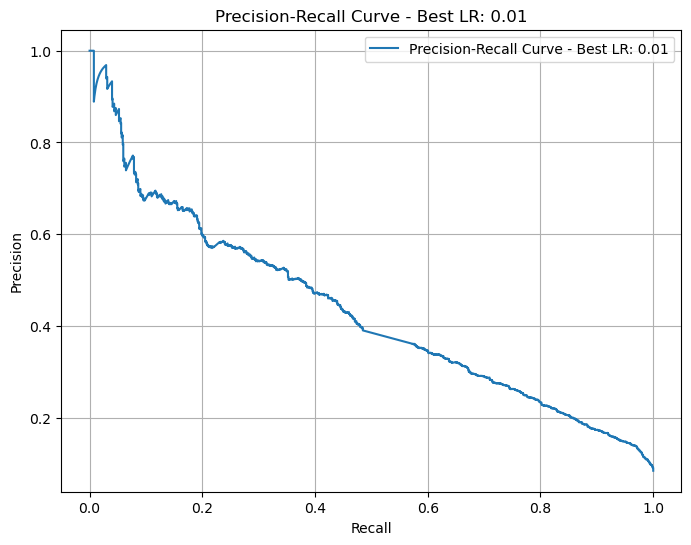

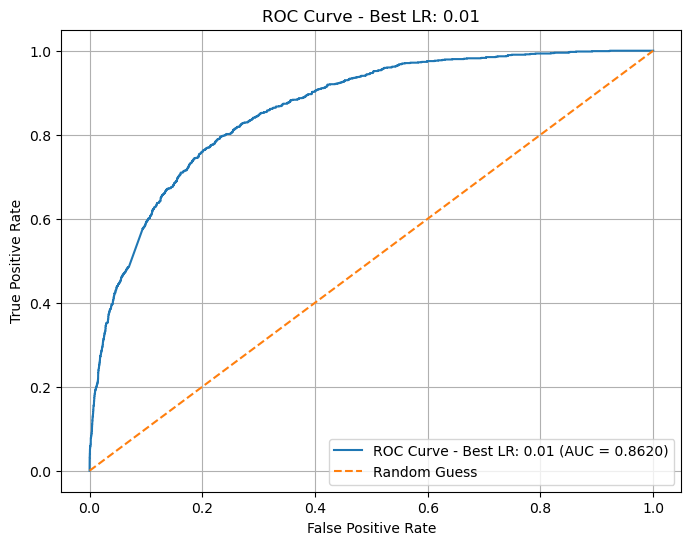

Test ROC AUC Score: 0.8620

=== Final Results ===
Best Learning Rate: 0.01
Test Loss: 0.2133
Test Accuracy: 0.7217
Test ROC AUC: 0.8620


In [ ]:
# Run with multiple learning rates and test the best model
learning_rates = [0.01,0.001,0.0001]
modelX=NeuralNet(X_train_tensor.shape[1])
best_lr, test_loss, test_accuracy, roc_auc, best_model = train_eval_find_best_lr_test(
    modelX,
    X_train_tensor, Y_train_tensor,
    X_val_tensor, Y_val_tensor,
    X_test_tensor, Y_test_tensor,
    lrs=learning_rates,
    description="Learning Rate Search and Testing"
)

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

In [ ]:

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")


=== Running with Learning Rate: 0.01 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 697.29batch/s, loss=0.343] 


Epoch 1/50: Train Loss = 0.2271, Val Loss = 0.2115, Val Accuracy = 0.9249


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 671.82batch/s, loss=0.344] 


Epoch 2/50: Train Loss = 0.2131, Val Loss = 0.2081, Val Accuracy = 0.9258


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 679.36batch/s, loss=0.357] 


Epoch 3/50: Train Loss = 0.2088, Val Loss = 0.2082, Val Accuracy = 0.9269


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 696.01batch/s, loss=0.351] 


Epoch 4/50: Train Loss = 0.2070, Val Loss = 0.2081, Val Accuracy = 0.9259


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 675.98batch/s, loss=0.343] 


Epoch 5/50: Train Loss = 0.2038, Val Loss = 0.2075, Val Accuracy = 0.9271


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 726.12batch/s, loss=0.338] 


Epoch 6/50: Train Loss = 0.1987, Val Loss = 0.2109, Val Accuracy = 0.9241


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 725.70batch/s, loss=0.33]  


Epoch 7/50: Train Loss = 0.1962, Val Loss = 0.2090, Val Accuracy = 0.9269


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 748.67batch/s, loss=0.319] 


Epoch 8/50: Train Loss = 0.1962, Val Loss = 0.2147, Val Accuracy = 0.9237


Epoch 8: 100%|██████████| 666/666 [00:01<00:00, 662.31batch/s, loss=0.359] 


Epoch 9/50: Train Loss = 0.1940, Val Loss = 0.2082, Val Accuracy = 0.9271


Epoch 9: 100%|██████████| 666/666 [00:01<00:00, 646.10batch/s, loss=0.305] 


Epoch 10/50: Train Loss = 0.1932, Val Loss = 0.2117, Val Accuracy = 0.9261


Epoch 10: 100%|██████████| 666/666 [00:01<00:00, 636.55batch/s, loss=0.368] 


Epoch 11/50: Train Loss = 0.1924, Val Loss = 0.2161, Val Accuracy = 0.9197


Epoch 11: 100%|██████████| 666/666 [00:01<00:00, 646.75batch/s, loss=0.342] 


Epoch 12/50: Train Loss = 0.1937, Val Loss = 0.2113, Val Accuracy = 0.9279


Epoch 12: 100%|██████████| 666/666 [00:01<00:00, 661.95batch/s, loss=0.342] 


Epoch 13/50: Train Loss = 0.1868, Val Loss = 0.2140, Val Accuracy = 0.9263


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 700.64batch/s, loss=0.337] 


Epoch 14/50: Train Loss = 0.1889, Val Loss = 0.2181, Val Accuracy = 0.9241


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 716.24batch/s, loss=0.334] 


Epoch 15/50: Train Loss = 0.1844, Val Loss = 0.2228, Val Accuracy = 0.9208


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 722.51batch/s, loss=0.449] 


Epoch 16/50: Train Loss = 0.1837, Val Loss = 0.2258, Val Accuracy = 0.9246


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 713.97batch/s, loss=0.374] 


Epoch 17/50: Train Loss = 0.1894, Val Loss = 0.2197, Val Accuracy = 0.9259


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 669.24batch/s, loss=0.322] 


Epoch 18/50: Train Loss = 0.1788, Val Loss = 0.2259, Val Accuracy = 0.9267


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 673.52batch/s, loss=0.318] 


Epoch 19/50: Train Loss = 0.1746, Val Loss = 0.2321, Val Accuracy = 0.9233


Epoch 19: 100%|██████████| 666/666 [00:01<00:00, 647.37batch/s, loss=0.312] 


Epoch 20/50: Train Loss = 0.1769, Val Loss = 0.2388, Val Accuracy = 0.9222


Epoch 20: 100%|██████████| 666/666 [00:01<00:00, 652.00batch/s, loss=0.339] 


Epoch 21/50: Train Loss = 0.1711, Val Loss = 0.2891, Val Accuracy = 0.8934


Epoch 21: 100%|██████████| 666/666 [00:01<00:00, 659.77batch/s, loss=0.369] 


Epoch 22/50: Train Loss = 0.1699, Val Loss = 0.2444, Val Accuracy = 0.9208


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 701.95batch/s, loss=0.311] 


Epoch 23/50: Train Loss = 0.1652, Val Loss = 0.2404, Val Accuracy = 0.9186


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 732.89batch/s, loss=0.344] 


Epoch 24/50: Train Loss = 0.1731, Val Loss = 0.2801, Val Accuracy = 0.9089


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 711.80batch/s, loss=0.312] 


Epoch 25/50: Train Loss = 0.1739, Val Loss = 0.2686, Val Accuracy = 0.9178


Epoch 25: 100%|██████████| 666/666 [00:01<00:00, 649.65batch/s, loss=0.278] 


Epoch 26/50: Train Loss = 0.1624, Val Loss = 0.2625, Val Accuracy = 0.9173


Epoch 26: 100%|██████████| 666/666 [00:01<00:00, 648.94batch/s, loss=0.306] 


Epoch 27/50: Train Loss = 0.1574, Val Loss = 0.2974, Val Accuracy = 0.9132


Epoch 27: 100%|██████████| 666/666 [00:01<00:00, 623.84batch/s, loss=0.259] 


Epoch 28/50: Train Loss = 0.1573, Val Loss = 0.2824, Val Accuracy = 0.9064


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 685.86batch/s, loss=0.359] 


Epoch 29/50: Train Loss = 0.1534, Val Loss = 0.2994, Val Accuracy = 0.9144


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 732.69batch/s, loss=0.263] 


Epoch 30/50: Train Loss = 0.1489, Val Loss = 0.2892, Val Accuracy = 0.9104


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 695.67batch/s, loss=0.323] 


Epoch 31/50: Train Loss = 0.1564, Val Loss = 0.2856, Val Accuracy = 0.9197


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 694.48batch/s, loss=0.333] 


Epoch 32/50: Train Loss = 0.1509, Val Loss = 0.2790, Val Accuracy = 0.9153


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 689.89batch/s, loss=0.298] 


Epoch 33/50: Train Loss = 0.1543, Val Loss = 0.2823, Val Accuracy = 0.9149


Epoch 33: 100%|██████████| 666/666 [00:01<00:00, 656.86batch/s, loss=0.304] 


Epoch 34/50: Train Loss = 0.1618, Val Loss = 0.2819, Val Accuracy = 0.9172


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 675.52batch/s, loss=0.318] 


Epoch 35/50: Train Loss = 0.1561, Val Loss = 0.2892, Val Accuracy = 0.9182


Epoch 35: 100%|██████████| 666/666 [00:01<00:00, 643.75batch/s, loss=0.252] 


Epoch 36/50: Train Loss = 0.1472, Val Loss = 0.3017, Val Accuracy = 0.9186


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 671.65batch/s, loss=0.289] 


Epoch 37/50: Train Loss = 0.1473, Val Loss = 0.3454, Val Accuracy = 0.9109


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 715.64batch/s, loss=0.285] 


Epoch 38/50: Train Loss = 0.1474, Val Loss = 0.2771, Val Accuracy = 0.9040


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 734.76batch/s, loss=0.287] 


Epoch 39/50: Train Loss = 0.1591, Val Loss = 0.2691, Val Accuracy = 0.9186


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 713.02batch/s, loss=0.267] 


Epoch 40/50: Train Loss = 0.1502, Val Loss = 0.3106, Val Accuracy = 0.9169


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 698.27batch/s, loss=0.256] 


Epoch 41/50: Train Loss = 0.1400, Val Loss = 0.3617, Val Accuracy = 0.9128


Epoch 41: 100%|██████████| 666/666 [00:01<00:00, 653.37batch/s, loss=0.268] 


Epoch 42/50: Train Loss = 0.1379, Val Loss = 0.3465, Val Accuracy = 0.9112


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 667.26batch/s, loss=0.188] 


Epoch 43/50: Train Loss = 0.1348, Val Loss = 0.3460, Val Accuracy = 0.9091


Epoch 43: 100%|██████████| 666/666 [00:01<00:00, 646.23batch/s, loss=0.18]  


Epoch 44/50: Train Loss = 0.1271, Val Loss = 0.3838, Val Accuracy = 0.9061


Epoch 44: 100%|██████████| 666/666 [00:01<00:00, 636.63batch/s, loss=0.211] 


Epoch 45/50: Train Loss = 0.1308, Val Loss = 0.3983, Val Accuracy = 0.9109


Epoch 45: 100%|██████████| 666/666 [00:01<00:00, 619.20batch/s, loss=0.196] 


Epoch 46/50: Train Loss = 0.1258, Val Loss = 0.3997, Val Accuracy = 0.9084


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 670.86batch/s, loss=0.151] 


Epoch 47/50: Train Loss = 0.1198, Val Loss = 0.3934, Val Accuracy = 0.9039


Epoch 47: 100%|██████████| 666/666 [00:01<00:00, 621.85batch/s, loss=0.201] 


Epoch 48/50: Train Loss = 0.1252, Val Loss = 0.3815, Val Accuracy = 0.8911


Epoch 48: 100%|██████████| 666/666 [00:01<00:00, 649.98batch/s, loss=0.182] 


Epoch 49/50: Train Loss = 0.1269, Val Loss = 0.3468, Val Accuracy = 0.9083


Epoch 49: 100%|██████████| 666/666 [00:01<00:00, 656.61batch/s, loss=0.182] 


Epoch 50/50: Train Loss = 0.1199, Val Loss = 0.3930, Val Accuracy = 0.9015
Best Validation Loss: 0.2075

=== Running with Learning Rate: 0.001 ===


Epoch 0: 100%|██████████| 666/666 [00:01<00:00, 657.66batch/s, loss=0.179] 


Epoch 1/50: Train Loss = 0.1004, Val Loss = 0.4253, Val Accuracy = 0.9088


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 670.80batch/s, loss=0.173] 


Epoch 2/50: Train Loss = 0.0921, Val Loss = 0.4863, Val Accuracy = 0.9083


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 697.05batch/s, loss=0.169] 


Epoch 3/50: Train Loss = 0.0875, Val Loss = 0.5516, Val Accuracy = 0.9085


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 701.37batch/s, loss=0.16]  


Epoch 4/50: Train Loss = 0.0843, Val Loss = 0.6240, Val Accuracy = 0.9083


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 724.07batch/s, loss=0.165] 


Epoch 5/50: Train Loss = 0.0820, Val Loss = 0.6891, Val Accuracy = 0.9069


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 677.67batch/s, loss=0.154] 


Epoch 6/50: Train Loss = 0.0795, Val Loss = 0.7595, Val Accuracy = 0.9060


Epoch 6: 100%|██████████| 666/666 [00:01<00:00, 627.61batch/s, loss=0.151] 


Epoch 7/50: Train Loss = 0.0776, Val Loss = 0.8368, Val Accuracy = 0.9069


Epoch 7: 100%|██████████| 666/666 [00:01<00:00, 640.99batch/s, loss=0.154] 


Epoch 8/50: Train Loss = 0.0772, Val Loss = 0.8769, Val Accuracy = 0.9039


Epoch 8: 100%|██████████| 666/666 [00:01<00:00, 655.63batch/s, loss=0.148] 


Epoch 9/50: Train Loss = 0.0753, Val Loss = 0.9117, Val Accuracy = 0.9067


Epoch 9: 100%|██████████| 666/666 [00:01<00:00, 658.29batch/s, loss=0.151]  


Epoch 10/50: Train Loss = 0.0736, Val Loss = 0.9789, Val Accuracy = 0.9049


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 692.23batch/s, loss=0.143]  


Epoch 11/50: Train Loss = 0.0728, Val Loss = 1.0488, Val Accuracy = 0.9037


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 702.48batch/s, loss=0.131]  


Epoch 12/50: Train Loss = 0.0712, Val Loss = 1.0640, Val Accuracy = 0.9035


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 727.40batch/s, loss=0.128]  


Epoch 13/50: Train Loss = 0.0704, Val Loss = 1.1088, Val Accuracy = 0.9027


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 683.14batch/s, loss=0.128]  


Epoch 14/50: Train Loss = 0.0689, Val Loss = 1.1691, Val Accuracy = 0.9031


Epoch 14: 100%|██████████| 666/666 [00:01<00:00, 619.27batch/s, loss=0.131]  


Epoch 15/50: Train Loss = 0.0682, Val Loss = 1.2113, Val Accuracy = 0.9008


Epoch 15: 100%|██████████| 666/666 [00:01<00:00, 635.21batch/s, loss=0.131]  


Epoch 16/50: Train Loss = 0.0671, Val Loss = 1.2383, Val Accuracy = 0.9068


Epoch 16: 100%|██████████| 666/666 [00:01<00:00, 631.80batch/s, loss=0.118]  


Epoch 17/50: Train Loss = 0.0666, Val Loss = 1.2611, Val Accuracy = 0.9037


Epoch 17: 100%|██████████| 666/666 [00:01<00:00, 650.69batch/s, loss=0.12]   


Epoch 18/50: Train Loss = 0.0651, Val Loss = 1.2647, Val Accuracy = 0.9028


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 698.93batch/s, loss=0.119]  


Epoch 19/50: Train Loss = 0.0646, Val Loss = 1.2795, Val Accuracy = 0.8992


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 696.78batch/s, loss=0.12]   


Epoch 20/50: Train Loss = 0.0639, Val Loss = 1.3767, Val Accuracy = 0.9025


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 701.99batch/s, loss=0.119]  


Epoch 21/50: Train Loss = 0.0622, Val Loss = 1.4255, Val Accuracy = 0.9012


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 702.80batch/s, loss=0.122]  


Epoch 22/50: Train Loss = 0.0616, Val Loss = 1.4344, Val Accuracy = 0.9008


Epoch 22: 100%|██████████| 666/666 [00:01<00:00, 628.30batch/s, loss=0.118]   


Epoch 23/50: Train Loss = 0.0608, Val Loss = 1.4807, Val Accuracy = 0.9015


Epoch 23: 100%|██████████| 666/666 [00:01<00:00, 625.32batch/s, loss=0.109]   


Epoch 24/50: Train Loss = 0.0598, Val Loss = 1.5351, Val Accuracy = 0.9017


Epoch 24: 100%|██████████| 666/666 [00:01<00:00, 619.00batch/s, loss=0.106]   


Epoch 25/50: Train Loss = 0.0589, Val Loss = 1.5027, Val Accuracy = 0.9004


Epoch 25: 100%|██████████| 666/666 [00:01<00:00, 611.89batch/s, loss=0.109]   


Epoch 26/50: Train Loss = 0.0589, Val Loss = 1.4882, Val Accuracy = 0.8992


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 722.59batch/s, loss=0.185]   


Epoch 27/50: Train Loss = 0.0581, Val Loss = 1.5430, Val Accuracy = 0.9013


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 697.19batch/s, loss=0.1]     


Epoch 28/50: Train Loss = 0.0567, Val Loss = 1.5573, Val Accuracy = 0.8991


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 692.83batch/s, loss=0.108]   


Epoch 29/50: Train Loss = 0.0564, Val Loss = 1.5484, Val Accuracy = 0.8976


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 691.86batch/s, loss=0.114]  


Epoch 30/50: Train Loss = 0.0556, Val Loss = 1.6110, Val Accuracy = 0.8976


Epoch 30: 100%|██████████| 666/666 [00:01<00:00, 649.65batch/s, loss=0.107]   


Epoch 31/50: Train Loss = 0.0539, Val Loss = 1.6548, Val Accuracy = 0.8992


Epoch 31: 100%|██████████| 666/666 [00:01<00:00, 622.61batch/s, loss=0.103]   


Epoch 32/50: Train Loss = 0.0534, Val Loss = 1.7182, Val Accuracy = 0.8983


Epoch 32: 100%|██████████| 666/666 [00:01<00:00, 629.14batch/s, loss=0.103]   


Epoch 33/50: Train Loss = 0.0532, Val Loss = 1.6501, Val Accuracy = 0.8979


Epoch 33: 100%|██████████| 666/666 [00:01<00:00, 649.45batch/s, loss=0.103]   


Epoch 34/50: Train Loss = 0.0524, Val Loss = 1.6978, Val Accuracy = 0.9000


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 721.54batch/s, loss=0.102]   


Epoch 35/50: Train Loss = 0.0511, Val Loss = 1.7965, Val Accuracy = 0.9005


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 691.92batch/s, loss=0.0967]  


Epoch 36/50: Train Loss = 0.0507, Val Loss = 1.7707, Val Accuracy = 0.8986


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 688.31batch/s, loss=0.0944]  


Epoch 37/50: Train Loss = 0.0493, Val Loss = 1.7988, Val Accuracy = 0.8984


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 686.50batch/s, loss=0.0891] 


Epoch 38/50: Train Loss = 0.0490, Val Loss = 1.7492, Val Accuracy = 0.8991


Epoch 38: 100%|██████████| 666/666 [00:01<00:00, 448.43batch/s, loss=0.0865] 


Epoch 39/50: Train Loss = 0.0475, Val Loss = 1.8387, Val Accuracy = 0.8979


Epoch 39: 100%|██████████| 666/666 [00:01<00:00, 568.72batch/s, loss=0.0896] 


Epoch 40/50: Train Loss = 0.0478, Val Loss = 1.8284, Val Accuracy = 0.8988


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 722.13batch/s, loss=0.0934] 


Epoch 41/50: Train Loss = 0.0464, Val Loss = 1.8820, Val Accuracy = 0.8996


Epoch 41: 100%|██████████| 666/666 [00:01<00:00, 651.50batch/s, loss=0.0906] 


Epoch 42/50: Train Loss = 0.0453, Val Loss = 1.9159, Val Accuracy = 0.8983


Epoch 42: 100%|██████████| 666/666 [00:01<00:00, 653.12batch/s, loss=0.0851] 


Epoch 43/50: Train Loss = 0.0443, Val Loss = 1.9427, Val Accuracy = 0.8955


Epoch 43: 100%|██████████| 666/666 [00:01<00:00, 633.65batch/s, loss=0.082]  


Epoch 44/50: Train Loss = 0.0444, Val Loss = 1.9954, Val Accuracy = 0.8983


Epoch 44: 100%|██████████| 666/666 [00:01<00:00, 643.79batch/s, loss=0.116]  


Epoch 45/50: Train Loss = 0.0434, Val Loss = 2.0119, Val Accuracy = 0.8991


Epoch 45: 100%|██████████| 666/666 [00:01<00:00, 647.85batch/s, loss=0.0713] 


Epoch 46/50: Train Loss = 0.0432, Val Loss = 1.9788, Val Accuracy = 0.8976


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 669.91batch/s, loss=0.0723] 


Epoch 47/50: Train Loss = 0.0414, Val Loss = 2.1056, Val Accuracy = 0.8976


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 686.58batch/s, loss=0.0659] 


Epoch 48/50: Train Loss = 0.0409, Val Loss = 2.0834, Val Accuracy = 0.8954


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 691.28batch/s, loss=0.066]  


Epoch 49/50: Train Loss = 0.0398, Val Loss = 2.0903, Val Accuracy = 0.8955


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 713.70batch/s, loss=0.0698] 


Epoch 50/50: Train Loss = 0.0398, Val Loss = 2.1698, Val Accuracy = 0.8970
Best Validation Loss: 0.4253

=== Running with Learning Rate: 0.0001 ===


Epoch 0: 100%|██████████| 666/666 [00:01<00:00, 647.65batch/s, loss=0.0775] 


Epoch 1/50: Train Loss = 0.0397, Val Loss = 2.1880, Val Accuracy = 0.9011


Epoch 1: 100%|██████████| 666/666 [00:01<00:00, 629.04batch/s, loss=0.0785] 


Epoch 2/50: Train Loss = 0.0375, Val Loss = 2.1954, Val Accuracy = 0.9012


Epoch 2: 100%|██████████| 666/666 [00:01<00:00, 624.22batch/s, loss=0.0785] 


Epoch 3/50: Train Loss = 0.0369, Val Loss = 2.2099, Val Accuracy = 0.9012


Epoch 3: 100%|██████████| 666/666 [00:01<00:00, 604.78batch/s, loss=0.0778] 


Epoch 4/50: Train Loss = 0.0366, Val Loss = 2.2372, Val Accuracy = 0.9012


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 666.53batch/s, loss=0.0764] 


Epoch 5/50: Train Loss = 0.0364, Val Loss = 2.2552, Val Accuracy = 0.9017


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 680.15batch/s, loss=0.0755] 


Epoch 6/50: Train Loss = 0.0362, Val Loss = 2.2715, Val Accuracy = 0.9019


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 678.09batch/s, loss=0.0746] 


Epoch 7/50: Train Loss = 0.0360, Val Loss = 2.2895, Val Accuracy = 0.9024


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 676.37batch/s, loss=0.0739] 


Epoch 8/50: Train Loss = 0.0358, Val Loss = 2.3033, Val Accuracy = 0.9027


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 667.35batch/s, loss=0.0736] 


Epoch 9/50: Train Loss = 0.0356, Val Loss = 2.3215, Val Accuracy = 0.9023


Epoch 9: 100%|██████████| 666/666 [00:01<00:00, 622.73batch/s, loss=0.0731] 


Epoch 10/50: Train Loss = 0.0355, Val Loss = 2.3397, Val Accuracy = 0.9021


Epoch 10: 100%|██████████| 666/666 [00:01<00:00, 614.23batch/s, loss=0.0725] 


Epoch 11/50: Train Loss = 0.0353, Val Loss = 2.3573, Val Accuracy = 0.9027


Epoch 11: 100%|██████████| 666/666 [00:01<00:00, 624.05batch/s, loss=0.0716] 


Epoch 12/50: Train Loss = 0.0351, Val Loss = 2.3759, Val Accuracy = 0.9029


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 684.65batch/s, loss=0.0714] 


Epoch 13/50: Train Loss = 0.0349, Val Loss = 2.3837, Val Accuracy = 0.9031


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 672.78batch/s, loss=0.0709] 


Epoch 14/50: Train Loss = 0.0348, Val Loss = 2.4043, Val Accuracy = 0.9032


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 676.69batch/s, loss=0.0706] 


Epoch 15/50: Train Loss = 0.0346, Val Loss = 2.4166, Val Accuracy = 0.9036


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 678.32batch/s, loss=0.0701] 


Epoch 16/50: Train Loss = 0.0344, Val Loss = 2.4268, Val Accuracy = 0.9029


Epoch 16: 100%|██████████| 666/666 [00:01<00:00, 649.01batch/s, loss=0.0698] 


Epoch 17/50: Train Loss = 0.0342, Val Loss = 2.4560, Val Accuracy = 0.9033


Epoch 17: 100%|██████████| 666/666 [00:01<00:00, 596.61batch/s, loss=0.0695] 


Epoch 18/50: Train Loss = 0.0341, Val Loss = 2.4710, Val Accuracy = 0.9039


Epoch 18: 100%|██████████| 666/666 [00:01<00:00, 618.21batch/s, loss=0.0693] 


Epoch 19/50: Train Loss = 0.0339, Val Loss = 2.4767, Val Accuracy = 0.9035


Epoch 19: 100%|██████████| 666/666 [00:01<00:00, 636.63batch/s, loss=0.0689] 


Epoch 20/50: Train Loss = 0.0337, Val Loss = 2.4828, Val Accuracy = 0.9036


Epoch 20: 100%|██████████| 666/666 [00:01<00:00, 551.30batch/s, loss=0.0687] 


Epoch 21/50: Train Loss = 0.0336, Val Loss = 2.5040, Val Accuracy = 0.9039


Epoch 21: 100%|██████████| 666/666 [00:01<00:00, 646.16batch/s, loss=0.0684] 


Epoch 22/50: Train Loss = 0.0334, Val Loss = 2.5098, Val Accuracy = 0.9036


Epoch 22: 100%|██████████| 666/666 [00:01<00:00, 608.96batch/s, loss=0.0679] 


Epoch 23/50: Train Loss = 0.0333, Val Loss = 2.5345, Val Accuracy = 0.9041


Epoch 23: 100%|██████████| 666/666 [00:01<00:00, 491.06batch/s, loss=0.0678] 


Epoch 24/50: Train Loss = 0.0332, Val Loss = 2.5345, Val Accuracy = 0.9037


Epoch 24: 100%|██████████| 666/666 [00:01<00:00, 547.47batch/s, loss=0.0675] 


Epoch 25/50: Train Loss = 0.0330, Val Loss = 2.5463, Val Accuracy = 0.9036


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 670.83batch/s, loss=0.0673] 


Epoch 26/50: Train Loss = 0.0329, Val Loss = 2.5548, Val Accuracy = 0.9037


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 670.79batch/s, loss=0.0667] 


Epoch 27/50: Train Loss = 0.0327, Val Loss = 2.5699, Val Accuracy = 0.9037


Epoch 27: 100%|██████████| 666/666 [00:01<00:00, 606.10batch/s, loss=0.0663] 


Epoch 28/50: Train Loss = 0.0326, Val Loss = 2.5934, Val Accuracy = 0.9039


Epoch 28: 100%|██████████| 666/666 [00:01<00:00, 610.69batch/s, loss=0.0659] 


Epoch 29/50: Train Loss = 0.0324, Val Loss = 2.6009, Val Accuracy = 0.9037


Epoch 29: 100%|██████████| 666/666 [00:01<00:00, 621.08batch/s, loss=0.0656] 


Epoch 30/50: Train Loss = 0.0323, Val Loss = 2.6127, Val Accuracy = 0.9036


Epoch 30: 100%|██████████| 666/666 [00:01<00:00, 650.00batch/s, loss=0.0654] 


Epoch 31/50: Train Loss = 0.0322, Val Loss = 2.6228, Val Accuracy = 0.9035


Epoch 31: 100%|██████████| 666/666 [00:01<00:00, 656.52batch/s, loss=0.0654] 


Epoch 32/50: Train Loss = 0.0321, Val Loss = 2.6475, Val Accuracy = 0.9036


Epoch 32: 100%|██████████| 666/666 [00:01<00:00, 656.90batch/s, loss=0.065]  


Epoch 33/50: Train Loss = 0.0319, Val Loss = 2.6669, Val Accuracy = 0.9032


Epoch 33: 100%|██████████| 666/666 [00:01<00:00, 618.41batch/s, loss=0.0648] 


Epoch 34/50: Train Loss = 0.0318, Val Loss = 2.6794, Val Accuracy = 0.9032


Epoch 34: 100%|██████████| 666/666 [00:01<00:00, 586.55batch/s, loss=0.0646] 


Epoch 35/50: Train Loss = 0.0317, Val Loss = 2.6921, Val Accuracy = 0.9032


Epoch 35: 100%|██████████| 666/666 [00:01<00:00, 607.01batch/s, loss=0.0644] 


Epoch 36/50: Train Loss = 0.0315, Val Loss = 2.6955, Val Accuracy = 0.9031


Epoch 36: 100%|██████████| 666/666 [00:01<00:00, 629.08batch/s, loss=0.0645] 


Epoch 37/50: Train Loss = 0.0314, Val Loss = 2.6990, Val Accuracy = 0.9035


Epoch 37: 100%|██████████| 666/666 [00:01<00:00, 656.48batch/s, loss=0.0637] 


Epoch 38/50: Train Loss = 0.0312, Val Loss = 2.7116, Val Accuracy = 0.9033


Epoch 38: 100%|██████████| 666/666 [00:01<00:00, 660.12batch/s, loss=0.0633] 


Epoch 39/50: Train Loss = 0.0311, Val Loss = 2.7223, Val Accuracy = 0.9032


Epoch 39: 100%|██████████| 666/666 [00:01<00:00, 657.04batch/s, loss=0.0631] 


Epoch 40/50: Train Loss = 0.0310, Val Loss = 2.7264, Val Accuracy = 0.9031


Epoch 40: 100%|██████████| 666/666 [00:01<00:00, 602.11batch/s, loss=0.0629] 


Epoch 41/50: Train Loss = 0.0308, Val Loss = 2.7354, Val Accuracy = 0.9032


Epoch 41: 100%|██████████| 666/666 [00:01<00:00, 620.32batch/s, loss=0.0627] 


Epoch 42/50: Train Loss = 0.0307, Val Loss = 2.7479, Val Accuracy = 0.9033


Epoch 42: 100%|██████████| 666/666 [00:01<00:00, 599.73batch/s, loss=0.0624] 


Epoch 43/50: Train Loss = 0.0306, Val Loss = 2.7545, Val Accuracy = 0.9027


Epoch 43: 100%|██████████| 666/666 [00:01<00:00, 623.33batch/s, loss=0.0625] 


Epoch 44/50: Train Loss = 0.0305, Val Loss = 2.7626, Val Accuracy = 0.9025


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 676.21batch/s, loss=0.0623] 


Epoch 45/50: Train Loss = 0.0303, Val Loss = 2.7723, Val Accuracy = 0.9023


Epoch 45: 100%|██████████| 666/666 [00:01<00:00, 661.80batch/s, loss=0.0621] 


Epoch 46/50: Train Loss = 0.0302, Val Loss = 2.7770, Val Accuracy = 0.9020


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 681.32batch/s, loss=0.0619] 


Epoch 47/50: Train Loss = 0.0301, Val Loss = 2.8003, Val Accuracy = 0.9020


Epoch 47: 100%|██████████| 666/666 [00:01<00:00, 606.99batch/s, loss=0.0618] 


Epoch 48/50: Train Loss = 0.0300, Val Loss = 2.8012, Val Accuracy = 0.9021


Epoch 48: 100%|██████████| 666/666 [00:01<00:00, 607.55batch/s, loss=0.0616] 


Epoch 49/50: Train Loss = 0.0299, Val Loss = 2.8064, Val Accuracy = 0.9019


Epoch 49: 100%|██████████| 666/666 [00:01<00:00, 591.30batch/s, loss=0.0614] 


Epoch 50/50: Train Loss = 0.0297, Val Loss = 2.8173, Val Accuracy = 0.9021
Best Validation Loss: 2.1880

=== Best Learning Rate: 0.01 ===
Best Validation Loss: 0.2075

Best Threshold: 0.10, Best TPR: 0.7451

=== Testing Model: Best LR: 0.01 ===
Test Loss: 0.2096, Test Accuracy: 0.7955

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88     11480
         1.0       0.26      0.76      0.38      1054

    accuracy                           0.80     12534
   macro avg       0.62      0.78      0.63     12534
weighted avg       0.91      0.80      0.84     12534


Confusion Matrix:
[[9171 2309]
 [ 254  800]]


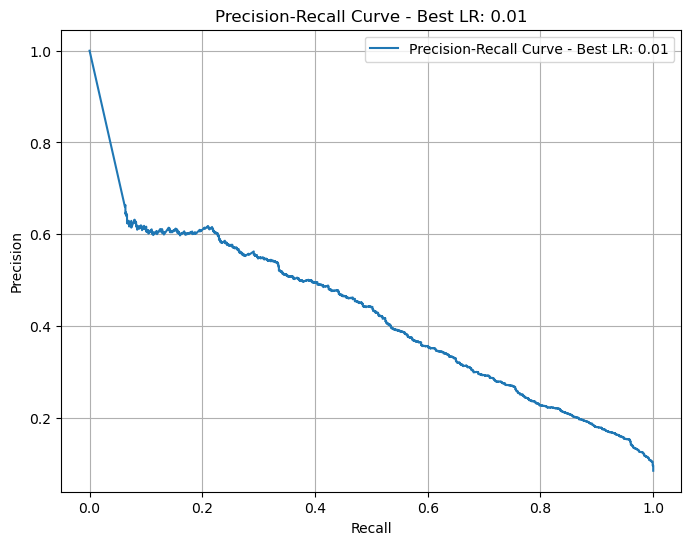

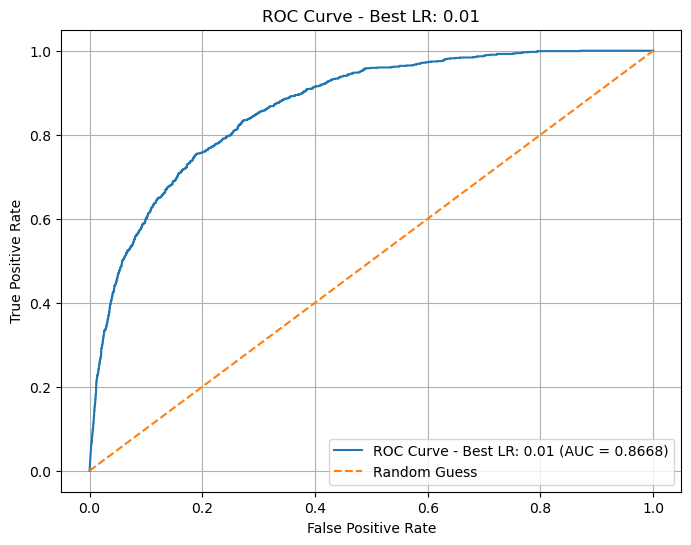

Test ROC AUC Score: 0.8668

=== Final Results ===
Best Learning Rate: 0.01
Test Loss: 0.2096
Test Accuracy: 0.7955
Test ROC AUC: 0.8668


In [23]:
# Run with multiple learning rates and test the best model
learning_rates = [0.01,0.001,0.0001]
modelY=BigModel(X_train_tensor.shape[1])
best_lr, test_loss, test_accuracy, roc_auc, best_model = train_eval_find_best_lr_test(
    modelY,
    X_train_tensor, Y_train_tensor,
    X_val_tensor, Y_val_tensor,
    X_test_tensor, Y_test_tensor,
    lrs=learning_rates,
    description="Learning Rate Search and Testing"
)

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

In [6]:
# learning_rates = [0.01,0.001,0.0001]
# modelB=BigModel(X_train_smote_tensor.shape[1])

# best_lr, test_loss, test_accuracy, roc_auc, best_model = train_eval_find_best_lr_test(
#     modelB,
#     X_train_smote_tensor, Y_train_smote_tensor,
#     X_val_tensor, Y_val_tensor,
#     X_test_tensor, Y_test_tensor,
#     lrs=learning_rates,
#     description="Learning Rate Search and Testing"
# )
# print(f"\n=== Final Results ===")
# print(f"Best Learning Rate: {best_lr}")
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print(f"Test ROC AUC: {roc_auc:.4f}")

In [9]:
# Step 5: Define the ToyModel and adjust it for the dataset
class ToyModel(nn.Module):
    def __init__(self, input_size):
        super(ToyModel, self).__init__()
        self.lin1 = nn.Linear(input_size, 3)  # Modified to accept the input_size of the dataset
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(3, 1)  # Modified output to 1 for binary classification

        # Initialize weights and biases (Optional: to match ToyModel style, or you can let it randomly initialize)
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.zeros_(self.lin1.bias)
        nn.init.xavier_uniform_(self.lin2.weight)
        nn.init.zeros_(self.lin2.bias)

    def forward(self, input):
        return torch.sigmoid(self.lin2(self.relu(self.lin1(input))))

In [10]:
# Step 8: Interpret the ToyModel using Captum
def interpret_model(model, X_sample, description=""):
    """
    Uses Integrated Gradients from Captum to interpret the model.
    """
    model.eval()
    ig = IntegratedGradients(model)

    X_sample_tensor = torch.tensor(X_sample, dtype=torch.float32).requires_grad_()
    baseline = torch.zeros_like(X_sample_tensor)  # Baseline of all zeros

    # Calculate attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_sample_tensor, baseline, target=0, return_convergence_delta=True)

    # Plot attributions
    plt.figure(figsize=(10, 6))
    plt.bar(range(X_sample_tensor.shape[1]), attributions.detach().numpy()[0], color='skyblue')
    plt.xlabel('Feature Index')
    plt.ylabel('Attribution Value')
    plt.title(f'Feature Attributions - {description}')
    plt.grid(True)
    plt.show()


=== Running with Learning Rate: 0.01 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 903.89batch/s, loss=0.338]  


Epoch 1/50: Train Loss = 0.2516, Val Loss = 0.2117, Val Accuracy = 0.9247


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 1019.01batch/s, loss=0.375] 


Epoch 2/50: Train Loss = 0.2126, Val Loss = 0.2092, Val Accuracy = 0.9254


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 1010.95batch/s, loss=0.375] 


Epoch 3/50: Train Loss = 0.2103, Val Loss = 0.2082, Val Accuracy = 0.9247


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 1038.86batch/s, loss=0.379] 


Epoch 4/50: Train Loss = 0.2093, Val Loss = 0.2072, Val Accuracy = 0.9246


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 1011.32batch/s, loss=0.372] 


Epoch 5/50: Train Loss = 0.2087, Val Loss = 0.2073, Val Accuracy = 0.9239


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 1012.19batch/s, loss=0.377] 


Epoch 6/50: Train Loss = 0.2083, Val Loss = 0.2071, Val Accuracy = 0.9239


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 1027.85batch/s, loss=0.382] 


Epoch 7/50: Train Loss = 0.2081, Val Loss = 0.2070, Val Accuracy = 0.9245


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 1050.87batch/s, loss=0.381] 


Epoch 8/50: Train Loss = 0.2077, Val Loss = 0.2070, Val Accuracy = 0.9245


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 968.48batch/s, loss=0.381]  


Epoch 9/50: Train Loss = 0.2076, Val Loss = 0.2069, Val Accuracy = 0.9235


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 957.19batch/s, loss=0.377]  


Epoch 10/50: Train Loss = 0.2075, Val Loss = 0.2067, Val Accuracy = 0.9242


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 980.70batch/s, loss=0.378]  


Epoch 11/50: Train Loss = 0.2072, Val Loss = 0.2068, Val Accuracy = 0.9237


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 1028.31batch/s, loss=0.377] 


Epoch 12/50: Train Loss = 0.2071, Val Loss = 0.2069, Val Accuracy = 0.9237


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 1006.35batch/s, loss=0.382] 


Epoch 13/50: Train Loss = 0.2071, Val Loss = 0.2070, Val Accuracy = 0.9241


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 1011.27batch/s, loss=0.378] 


Epoch 14/50: Train Loss = 0.2070, Val Loss = 0.2072, Val Accuracy = 0.9238


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 985.06batch/s, loss=0.383]  


Epoch 15/50: Train Loss = 0.2070, Val Loss = 0.2072, Val Accuracy = 0.9245


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 935.96batch/s, loss=0.383]  


Epoch 16/50: Train Loss = 0.2070, Val Loss = 0.2071, Val Accuracy = 0.9235


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 1016.29batch/s, loss=0.384] 


Epoch 17/50: Train Loss = 0.2069, Val Loss = 0.2071, Val Accuracy = 0.9245


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 952.87batch/s, loss=0.385]  


Epoch 18/50: Train Loss = 0.2068, Val Loss = 0.2071, Val Accuracy = 0.9243


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 1074.61batch/s, loss=0.386] 


Epoch 19/50: Train Loss = 0.2068, Val Loss = 0.2072, Val Accuracy = 0.9239


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 1011.93batch/s, loss=0.386] 


Epoch 20/50: Train Loss = 0.2067, Val Loss = 0.2072, Val Accuracy = 0.9241


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 1107.66batch/s, loss=0.383] 


Epoch 21/50: Train Loss = 0.2067, Val Loss = 0.2072, Val Accuracy = 0.9245


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 1078.61batch/s, loss=0.385] 


Epoch 22/50: Train Loss = 0.2067, Val Loss = 0.2071, Val Accuracy = 0.9242


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 1113.29batch/s, loss=0.382] 


Epoch 23/50: Train Loss = 0.2067, Val Loss = 0.2071, Val Accuracy = 0.9245


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 1082.27batch/s, loss=0.384] 


Epoch 24/50: Train Loss = 0.2067, Val Loss = 0.2071, Val Accuracy = 0.9241


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 1109.32batch/s, loss=0.386] 


Epoch 25/50: Train Loss = 0.2067, Val Loss = 0.2068, Val Accuracy = 0.9249


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 1079.78batch/s, loss=0.384] 


Epoch 26/50: Train Loss = 0.2066, Val Loss = 0.2071, Val Accuracy = 0.9239


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 1118.28batch/s, loss=0.385] 


Epoch 27/50: Train Loss = 0.2066, Val Loss = 0.2070, Val Accuracy = 0.9242


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 1111.11batch/s, loss=0.382] 


Epoch 28/50: Train Loss = 0.2066, Val Loss = 0.2071, Val Accuracy = 0.9237


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 1080.47batch/s, loss=0.385] 


Epoch 29/50: Train Loss = 0.2066, Val Loss = 0.2069, Val Accuracy = 0.9250


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 1122.01batch/s, loss=0.386] 


Epoch 30/50: Train Loss = 0.2065, Val Loss = 0.2070, Val Accuracy = 0.9243


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 1086.40batch/s, loss=0.385] 


Epoch 31/50: Train Loss = 0.2065, Val Loss = 0.2070, Val Accuracy = 0.9246


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 1121.87batch/s, loss=0.385] 


Epoch 32/50: Train Loss = 0.2065, Val Loss = 0.2070, Val Accuracy = 0.9243


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 1082.02batch/s, loss=0.382] 


Epoch 33/50: Train Loss = 0.2065, Val Loss = 0.2070, Val Accuracy = 0.9246


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 1111.64batch/s, loss=0.383] 


Epoch 34/50: Train Loss = 0.2064, Val Loss = 0.2071, Val Accuracy = 0.9250


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 1083.04batch/s, loss=0.384] 


Epoch 35/50: Train Loss = 0.2064, Val Loss = 0.2070, Val Accuracy = 0.9247


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 1118.53batch/s, loss=0.384] 


Epoch 36/50: Train Loss = 0.2064, Val Loss = 0.2072, Val Accuracy = 0.9245


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 1079.36batch/s, loss=0.384] 


Epoch 37/50: Train Loss = 0.2064, Val Loss = 0.2072, Val Accuracy = 0.9247


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 1125.36batch/s, loss=0.381] 


Epoch 38/50: Train Loss = 0.2064, Val Loss = 0.2073, Val Accuracy = 0.9247


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 965.06batch/s, loss=0.381]  


Epoch 39/50: Train Loss = 0.2064, Val Loss = 0.2073, Val Accuracy = 0.9246


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 1008.49batch/s, loss=0.385] 


Epoch 40/50: Train Loss = 0.2064, Val Loss = 0.2071, Val Accuracy = 0.9247


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 977.22batch/s, loss=0.383]  


Epoch 41/50: Train Loss = 0.2064, Val Loss = 0.2073, Val Accuracy = 0.9245


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 999.20batch/s, loss=0.385]  


Epoch 42/50: Train Loss = 0.2064, Val Loss = 0.2071, Val Accuracy = 0.9247


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 1000.69batch/s, loss=0.379] 


Epoch 43/50: Train Loss = 0.2064, Val Loss = 0.2072, Val Accuracy = 0.9246


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 963.24batch/s, loss=0.382]  


Epoch 44/50: Train Loss = 0.2064, Val Loss = 0.2072, Val Accuracy = 0.9249


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 985.55batch/s, loss=0.383]  


Epoch 45/50: Train Loss = 0.2063, Val Loss = 0.2071, Val Accuracy = 0.9246


Epoch 45: 100%|██████████| 666/666 [00:00<00:00, 974.89batch/s, loss=0.385]  


Epoch 46/50: Train Loss = 0.2063, Val Loss = 0.2071, Val Accuracy = 0.9245


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 970.49batch/s, loss=0.383]  


Epoch 47/50: Train Loss = 0.2063, Val Loss = 0.2072, Val Accuracy = 0.9245


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 1006.22batch/s, loss=0.381] 


Epoch 48/50: Train Loss = 0.2063, Val Loss = 0.2073, Val Accuracy = 0.9245


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 1008.11batch/s, loss=0.383] 


Epoch 49/50: Train Loss = 0.2063, Val Loss = 0.2072, Val Accuracy = 0.9247


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 1038.56batch/s, loss=0.384] 


Epoch 50/50: Train Loss = 0.2063, Val Loss = 0.2072, Val Accuracy = 0.9246
Best Validation Loss: 0.2067

=== Running with Learning Rate: 0.001 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 1005.83batch/s, loss=0.385] 


Epoch 1/50: Train Loss = 0.2030, Val Loss = 0.2063, Val Accuracy = 0.9250


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 975.17batch/s, loss=0.385]  


Epoch 2/50: Train Loss = 0.2025, Val Loss = 0.2061, Val Accuracy = 0.9251


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 1011.24batch/s, loss=0.385] 


Epoch 3/50: Train Loss = 0.2023, Val Loss = 0.2059, Val Accuracy = 0.9251


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 1050.28batch/s, loss=0.385] 


Epoch 4/50: Train Loss = 0.2022, Val Loss = 0.2059, Val Accuracy = 0.9253


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 1014.50batch/s, loss=0.385] 


Epoch 5/50: Train Loss = 0.2022, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 1000.60batch/s, loss=0.384] 


Epoch 6/50: Train Loss = 0.2021, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 942.95batch/s, loss=0.384]  


Epoch 7/50: Train Loss = 0.2021, Val Loss = 0.2059, Val Accuracy = 0.9257


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 934.63batch/s, loss=0.384]  


Epoch 8/50: Train Loss = 0.2021, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 1071.64batch/s, loss=0.384] 


Epoch 9/50: Train Loss = 0.2021, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 1038.50batch/s, loss=0.384] 


Epoch 10/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9255


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 1106.75batch/s, loss=0.383] 


Epoch 11/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9258


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 1089.54batch/s, loss=0.383] 


Epoch 12/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9258


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 1126.69batch/s, loss=0.384] 


Epoch 13/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9259


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 1091.67batch/s, loss=0.383] 


Epoch 14/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9257


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 1131.52batch/s, loss=0.383] 


Epoch 15/50: Train Loss = 0.2020, Val Loss = 0.2059, Val Accuracy = 0.9257


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 1086.90batch/s, loss=0.384] 


Epoch 16/50: Train Loss = 0.2020, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 1084.18batch/s, loss=0.384] 


Epoch 17/50: Train Loss = 0.2020, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 1084.47batch/s, loss=0.384] 


Epoch 18/50: Train Loss = 0.2020, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 1129.02batch/s, loss=0.384] 


Epoch 19/50: Train Loss = 0.2020, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 1093.17batch/s, loss=0.384] 


Epoch 20/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 1127.72batch/s, loss=0.384] 


Epoch 21/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 1092.42batch/s, loss=0.383] 


Epoch 22/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 1129.14batch/s, loss=0.383] 


Epoch 23/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 1085.19batch/s, loss=0.383] 


Epoch 24/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 1125.33batch/s, loss=0.383] 


Epoch 25/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 1095.03batch/s, loss=0.383] 


Epoch 26/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 1125.47batch/s, loss=0.383] 


Epoch 27/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 1094.07batch/s, loss=0.383] 


Epoch 28/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 1135.40batch/s, loss=0.383] 


Epoch 29/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 1130.27batch/s, loss=0.383] 


Epoch 30/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 1093.23batch/s, loss=0.383] 


Epoch 31/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 1126.58batch/s, loss=0.383] 


Epoch 32/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9253


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 1094.17batch/s, loss=0.383] 


Epoch 33/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9253


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 1129.01batch/s, loss=0.383] 


Epoch 34/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 1091.63batch/s, loss=0.382] 


Epoch 35/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9254


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 1129.89batch/s, loss=0.383] 


Epoch 36/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9255


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 1101.94batch/s, loss=0.383] 


Epoch 37/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9255


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 1139.60batch/s, loss=0.383] 


Epoch 38/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 1100.73batch/s, loss=0.382] 


Epoch 39/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 1136.01batch/s, loss=0.383] 


Epoch 40/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 1094.49batch/s, loss=0.383] 


Epoch 41/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 1137.68batch/s, loss=0.382] 


Epoch 42/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 1096.54batch/s, loss=0.382] 


Epoch 43/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 1140.39batch/s, loss=0.382] 


Epoch 44/50: Train Loss = 0.2019, Val Loss = 0.2061, Val Accuracy = 0.9257


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 1103.77batch/s, loss=0.382] 


Epoch 45/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9257


Epoch 45: 100%|██████████| 666/666 [00:00<00:00, 1138.75batch/s, loss=0.382] 


Epoch 46/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 1139.24batch/s, loss=0.382] 


Epoch 47/50: Train Loss = 0.2019, Val Loss = 0.2060, Val Accuracy = 0.9254


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 1101.81batch/s, loss=0.382] 


Epoch 48/50: Train Loss = 0.2018, Val Loss = 0.2061, Val Accuracy = 0.9254


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 1085.63batch/s, loss=0.382] 


Epoch 49/50: Train Loss = 0.2018, Val Loss = 0.2060, Val Accuracy = 0.9255


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 1104.59batch/s, loss=0.382] 


Epoch 50/50: Train Loss = 0.2018, Val Loss = 0.2060, Val Accuracy = 0.9255
Best Validation Loss: 0.2059

=== Running with Learning Rate: 0.0001 ===


Epoch 0: 100%|██████████| 666/666 [00:00<00:00, 1139.74batch/s, loss=0.384] 


Epoch 1/50: Train Loss = 0.2015, Val Loss = 0.2057, Val Accuracy = 0.9266


Epoch 1: 100%|██████████| 666/666 [00:00<00:00, 1104.77batch/s, loss=0.384] 


Epoch 2/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9266


Epoch 2: 100%|██████████| 666/666 [00:00<00:00, 1141.72batch/s, loss=0.384] 


Epoch 3/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9266


Epoch 3: 100%|██████████| 666/666 [00:00<00:00, 1086.97batch/s, loss=0.384] 


Epoch 4/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 4: 100%|██████████| 666/666 [00:00<00:00, 1053.87batch/s, loss=0.384] 


Epoch 5/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9267


Epoch 5: 100%|██████████| 666/666 [00:00<00:00, 1101.40batch/s, loss=0.384] 


Epoch 6/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9267


Epoch 6: 100%|██████████| 666/666 [00:00<00:00, 1102.39batch/s, loss=0.384] 


Epoch 7/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 7: 100%|██████████| 666/666 [00:00<00:00, 1084.52batch/s, loss=0.383] 


Epoch 8/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 8: 100%|██████████| 666/666 [00:00<00:00, 1130.80batch/s, loss=0.383] 


Epoch 9/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 9: 100%|██████████| 666/666 [00:00<00:00, 1097.71batch/s, loss=0.383] 


Epoch 10/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 10: 100%|██████████| 666/666 [00:00<00:00, 1130.96batch/s, loss=0.383] 


Epoch 11/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 11: 100%|██████████| 666/666 [00:00<00:00, 1130.14batch/s, loss=0.383] 


Epoch 12/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 12: 100%|██████████| 666/666 [00:00<00:00, 1094.97batch/s, loss=0.383] 


Epoch 13/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 13: 100%|██████████| 666/666 [00:00<00:00, 1121.11batch/s, loss=0.383] 


Epoch 14/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 14: 100%|██████████| 666/666 [00:00<00:00, 1089.31batch/s, loss=0.383] 


Epoch 15/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 15: 100%|██████████| 666/666 [00:00<00:00, 1130.48batch/s, loss=0.383] 


Epoch 16/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 16: 100%|██████████| 666/666 [00:00<00:00, 1092.72batch/s, loss=0.383] 


Epoch 17/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 17: 100%|██████████| 666/666 [00:00<00:00, 1126.22batch/s, loss=0.383] 


Epoch 18/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 18: 100%|██████████| 666/666 [00:00<00:00, 1094.24batch/s, loss=0.383] 


Epoch 19/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9270


Epoch 19: 100%|██████████| 666/666 [00:00<00:00, 1136.85batch/s, loss=0.383] 


Epoch 20/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 20: 100%|██████████| 666/666 [00:00<00:00, 1096.14batch/s, loss=0.383] 


Epoch 21/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 21: 100%|██████████| 666/666 [00:00<00:00, 1136.22batch/s, loss=0.383] 


Epoch 22/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 22: 100%|██████████| 666/666 [00:00<00:00, 1088.29batch/s, loss=0.383] 


Epoch 23/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 23: 100%|██████████| 666/666 [00:00<00:00, 1127.57batch/s, loss=0.383] 


Epoch 24/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 24: 100%|██████████| 666/666 [00:00<00:00, 1095.68batch/s, loss=0.383] 


Epoch 25/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 25: 100%|██████████| 666/666 [00:00<00:00, 1132.22batch/s, loss=0.383] 


Epoch 26/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 26: 100%|██████████| 666/666 [00:00<00:00, 1127.16batch/s, loss=0.383] 


Epoch 27/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 27: 100%|██████████| 666/666 [00:00<00:00, 1091.91batch/s, loss=0.383] 


Epoch 28/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 28: 100%|██████████| 666/666 [00:00<00:00, 1128.46batch/s, loss=0.383] 


Epoch 29/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 29: 100%|██████████| 666/666 [00:00<00:00, 1093.85batch/s, loss=0.383] 


Epoch 30/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 30: 100%|██████████| 666/666 [00:00<00:00, 1134.70batch/s, loss=0.383] 


Epoch 31/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 31: 100%|██████████| 666/666 [00:00<00:00, 1089.07batch/s, loss=0.383] 


Epoch 32/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 32: 100%|██████████| 666/666 [00:00<00:00, 1135.45batch/s, loss=0.383] 


Epoch 33/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 33: 100%|██████████| 666/666 [00:00<00:00, 1093.44batch/s, loss=0.383] 


Epoch 34/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 34: 100%|██████████| 666/666 [00:00<00:00, 1132.89batch/s, loss=0.383] 


Epoch 35/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 35: 100%|██████████| 666/666 [00:00<00:00, 1096.03batch/s, loss=0.383] 


Epoch 36/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 36: 100%|██████████| 666/666 [00:00<00:00, 1134.54batch/s, loss=0.383] 


Epoch 37/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 37: 100%|██████████| 666/666 [00:00<00:00, 1101.48batch/s, loss=0.383] 


Epoch 38/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 38: 100%|██████████| 666/666 [00:00<00:00, 1136.56batch/s, loss=0.383] 


Epoch 39/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 39: 100%|██████████| 666/666 [00:00<00:00, 1088.99batch/s, loss=0.383] 


Epoch 40/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 40: 100%|██████████| 666/666 [00:00<00:00, 1118.57batch/s, loss=0.383] 


Epoch 41/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 41: 100%|██████████| 666/666 [00:00<00:00, 1091.13batch/s, loss=0.383] 


Epoch 42/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 42: 100%|██████████| 666/666 [00:00<00:00, 1128.38batch/s, loss=0.383] 


Epoch 43/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 43: 100%|██████████| 666/666 [00:00<00:00, 1131.40batch/s, loss=0.383] 


Epoch 44/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 44: 100%|██████████| 666/666 [00:00<00:00, 1098.99batch/s, loss=0.382] 


Epoch 45/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 45: 100%|██████████| 666/666 [00:00<00:00, 1138.36batch/s, loss=0.382] 


Epoch 46/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 46: 100%|██████████| 666/666 [00:00<00:00, 1086.96batch/s, loss=0.382] 


Epoch 47/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 47: 100%|██████████| 666/666 [00:00<00:00, 1129.08batch/s, loss=0.382] 


Epoch 48/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 48: 100%|██████████| 666/666 [00:00<00:00, 1087.99batch/s, loss=0.382] 


Epoch 49/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269


Epoch 49: 100%|██████████| 666/666 [00:00<00:00, 1133.34batch/s, loss=0.382] 


Epoch 50/50: Train Loss = 0.2014, Val Loss = 0.2058, Val Accuracy = 0.9269
Best Validation Loss: 0.2057

=== Best Learning Rate: 0.0001 ===
Best Validation Loss: 0.2057

Best Threshold: 0.10, Best TPR: 0.7435

=== Testing Model: Best LR: 0.0001 ===
Test Loss: 0.2075, Test Accuracy: 0.7953

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88     11480
         1.0       0.26      0.75      0.38      1054

    accuracy                           0.80     12534
   macro avg       0.61      0.77      0.63     12534
weighted avg       0.91      0.80      0.84     12534


Confusion Matrix:
[[9181 2299]
 [ 267  787]]


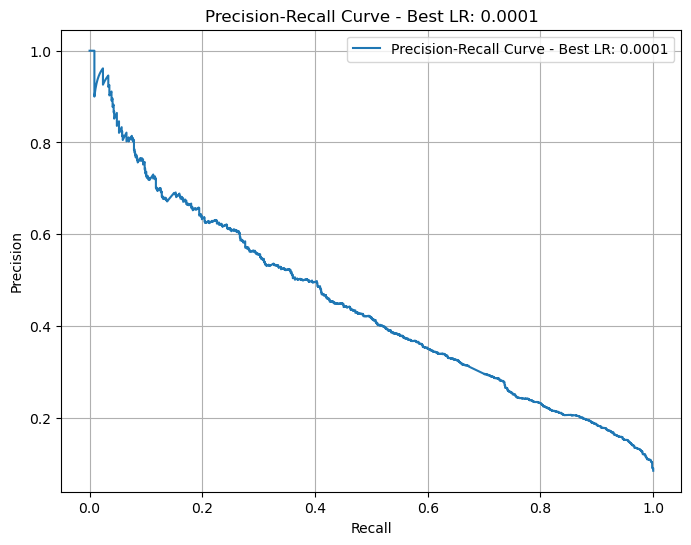

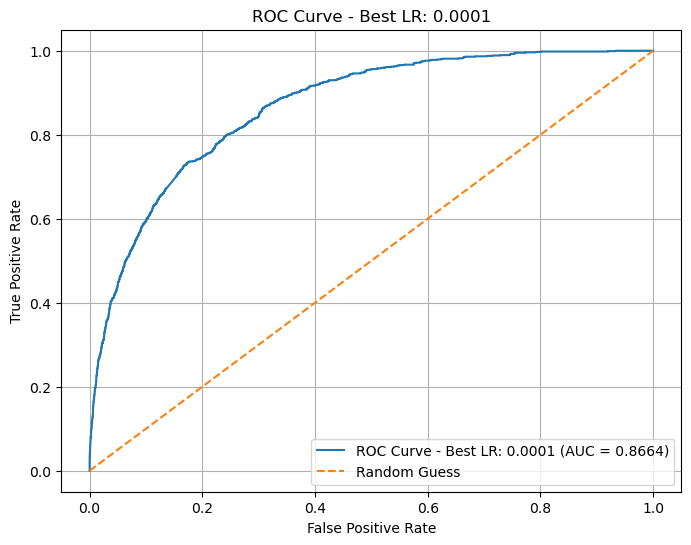

Test ROC AUC Score: 0.8664


ValueError: too many values to unpack (expected 3)

In [29]:
# Run with multiple learning rates and interpret the ToyModel
learning_rates = [0.01, 0.001, 0.0001]
modelTM = ToyModel(input_size=X_train_tensor.shape[1])
best_lr, best_model, best_threshold = train_eval_find_best_lr_test(
    modelTM,
    X_train_tensor, Y_train_tensor,
    X_val_tensor, Y_val_tensor,
    X_test_tensor, Y_test_tensor,
    lrs=learning_rates,
    description="Learning Rate Search with ToyModel"
)

print(f"\n=== Final Results ===")
print(f"Best Learning Rate: {best_lr}")

# Interpret the model using Captum
X_sample = X_test_tensor[:1]  # Take a sample from the test set for interpretation
interpret_model(best_model, X_sample, description="Final ToyModel Interpretation")